### Import data & necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!pip install --upgrade numpy
#!pip install --upgrade pmdarima

In [3]:
# Install required packages
#!pip install tensorflow pandas numpy matplotlib seaborn

In [4]:
# Install libraries if needed
# !pip install tensorflow pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error # Import mean_absolute_error

import tensorflow as tf
import random
import os

# Set random seeds for reproducibility
SEED = 202504
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load data
df = pd.read_csv('/content/drive/MyDrive/Quarter 2/Gold Price Prediction/[revised]_gold price prediction.csv')
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,Gold Price,Oil Crude,US Dollar Index,S&P 500
date,,,,
2025-02-28,2836.800049,69.760002,107.610001,5954.500000
2025-02-27,2883.199951,70.349998,107.239998,5861.569824
2025-02-26,2916.800049,68.620003,106.419998,5956.060059
2025-02-25,2904.500000,68.930000,106.309998,5955.250000
2025-02-24,2947.899902,70.699997,106.599998,5983.250000


In [5]:
# Define features and target
features = ['Oil Crude', 'US Dollar Index', 'S&P 500']
target = ['Gold Price']

# Train-test split BEFORE scaling
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Scaling
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_features_scaled = scaler_features.fit_transform(train[features])
test_features_scaled = scaler_features.transform(test[features])

train_target_scaled = scaler_target.fit_transform(train[target])
test_target_scaled = scaler_target.transform(test[target])

# Combine scaled features and target for sequence creation
train_combined = np.hstack((train_features_scaled, train_target_scaled))
test_combined = np.hstack((test_features_scaled, test_target_scaled))

# Sequence creation
def create_sequences(X, y, time_steps=15):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 15
X_train, y_train = create_sequences(train_combined, train_target_scaled, time_steps)
X_test, y_test = create_sequences(test_combined, test_target_scaled, time_steps)

In [6]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 - 7s - 53ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 2/100
140/140 - 2s - 14ms/step - loss: 0.0018 - val_loss: 5.1294e-04
Epoch 3/100
140/140 - 3s - 18ms/step - loss: 0.0016 - val_loss: 3.6041e-04
Epoch 4/100
140/140 - 2s - 13ms/step - loss: 0.0016 - val_loss: 2.3265e-04
Epoch 5/100
140/140 - 2s - 13ms/step - loss: 0.0015 - val_loss: 5.7820e-04
Epoch 6/100
140/140 - 2s - 16ms/step - loss: 0.0014 - val_loss: 4.0597e-04
Epoch 7/100
140/140 - 3s - 23ms/step - loss: 0.0012 - val_loss: 1.9780e-04
Epoch 8/100
140/140 - 4s - 30ms/step - loss: 0.0013 - val_loss: 1.9683e-04
Epoch 9/100
140/140 - 2s - 14ms/step - loss: 0.0011 - val_loss: 1.6419e-04
Epoch 10/100
140/140 - 3s - 18ms/step - loss: 0.0010 - val_loss: 1.5997e-04
Epoch 11/100
140/140 - 3s - 25ms/step - loss: 0.0012 - val_loss: 1.9033e-04
Epoch 12/100
140/140 - 4s - 30ms/step - loss: 9.8411e-04 - val_loss: 2.9130e-04
Epoch 13/100
140/140 - 2s - 17ms/step - loss: 9.2206e-04 - val_loss: 4.7292e-04
Epoch 14/100
140/140 - 2s - 1

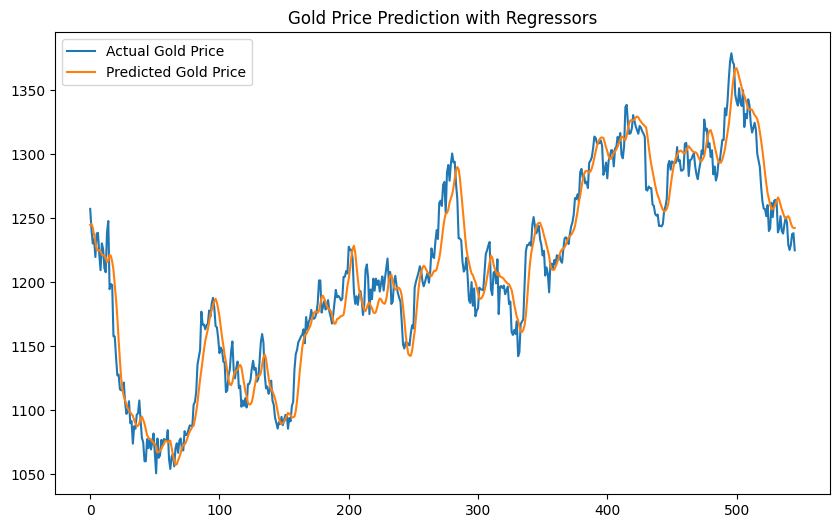

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model (Add callbacks=[early_stop])
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=2
)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform
y_train_pred = scaler_target.inverse_transform(y_train_pred)
y_test_pred = scaler_target.inverse_transform(y_test_pred)
y_train = scaler_target.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Metrics
rss_train = np.sum((y_train - y_train_pred) ** 2)
n_train = len(y_train)
k = np.sum([np.prod(v.shape) for v in model.trainable_variables])
aic_train = 2 * k + n_train * np.log(rss_train + 1e-8 / n_train)

mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"LSTM - MAE: {mae:.2f}, RMSE: {rmse:.2f}, AIC: {aic_train:.2f}")

# Plot predictions
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Gold Price')
plt.plot(y_test_pred, label='Predicted Gold Price')
plt.legend()
plt.title('Gold Price Prediction with Regressors')
plt.show()


**Scale of Gold Prices:**
With gold prices ranging from 2836 to 2947 USD, an RMSE of 17.74 translates to an average error of about 0.61% error relative to the gold price level, which is relatiely small.

**Market Volatility Context:**
Given that gold prices can fluctuate $30-$40 daily, a $17.74 error falls within normal market movements, making the model’s predictions reasonable.

**Use-Case Relevance:**
For mid- to long-term forecasting (e.g., 30-200 trading days ahead), this level of error is acceptable. Stricter accuracy would only be needed for short-term trading.

In [8]:
def forecast_future(model, last_window, steps, scaler_target):
    future_preds = []
    current_window = last_window.copy()

    for _ in range(steps):
        pred = model.predict(current_window[np.newaxis, :, :])[0, 0]  # Predict next gold price (scaled)
        future_preds.append(pred)

        # Update window (slide forward)
        next_window = np.vstack((current_window[1:], np.append(current_window[-1, :-1], pred)))  # Keep features static
        current_window = next_window

    # Inverse transform predictions
    future_preds = scaler_target.inverse_transform(np.array(future_preds).reshape(-1,1)).flatten()
    return future_preds

# Last available window from test set
last_window = X_test[-1]

# Forecast 30, 60, and until December 2025
future_30 = forecast_future(model, last_window, 30, scaler_target)
future_60 = forecast_future(model, last_window, 60, scaler_target)

# If December 2025 is ~200 trading days away (adjust based on your data frequency)
future_dec = forecast_future(model, last_window, 200, scaler_target)

# Last actual gold price
last_actual_price = y_test[-1][0]

# Calculate percentage changes
change_30 = (future_30[-1] - last_actual_price) / last_actual_price * 100
change_60 = (future_60[-1] - last_actual_price) / last_actual_price * 100
change_dec = (future_dec[-1] - last_actual_price) / last_actual_price * 100

print(f"Predicted Percentage Change Gold Price in 30 days: ({change_30:.2f}% change)")
print(f"Predicted Percentage Change Gold Price in 60 days: ({change_60:.2f}% change)")
print(f"Predicted Percentage Change Gold Price in December 2025: ({change_dec:.2f}% change)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

Based on our LSTM-based forecast, gold prices are projected to rise approximately 4.84% over the next 30 days, 6.91% over the next 60 days, and 9.22% by December 2025. This suggests a steady upward trend, making a strategic investment now potentially favorable for medium- to long-term gains. As always, we recommend diversifying and monitoring market conditions.